# Data Analysis

## Build Enviornment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def plot_lines(metric, period_start=0, period_end='end'):
    """Plot trend lines for metric over periods. Periods include [1, 7, 30, 90, 365]"""

    periods = [1, 7, 30, 90, 365]
    if period_end == 'end':
        period_end = len(periods)
    else:
        if period_end > len(periods):
            period_end = len(periods)

    # Inistantiate Figure
    plt.figure(figsize=(w, h))

    # Trend lines
    min_period = np.inf
    for period in periods[period_start:period_end]:
        if period == 1:
            sns.lineplot(data=data_daily_roll[metric], color=color_dict[f'{period}day'])    
        else:
            sns.lineplot(data=data_daily_roll.loc[(data_daily_roll[f'{metric}_roll_{period}'] != 0).idxmax():,f'{metric}_roll_{period}'], color=color_dict[f'{period}day'])
        if period < min_period:
            min_period = period

    # Add quarterly breaks
    if min_period == 1:
        new_date = pd.to_datetime(str(data_daily_roll.index[0].year) + '-1-1')    # get minimum quarterly line from index of smallest period
        upper_bound = data_daily_roll[metric].max() + (data_daily_roll[metric].max() * .02)   # get maximum height + 2% of smallest period
    else:
        new_date = pd.to_datetime(str((data_daily_roll[f'{metric}_roll_{min_period}'] != 0).idxmax().year) + '-1-1')    # get minimum quarterly line from index of smallest period
        upper_bound = data_daily_roll[f'{metric}_roll_{min_period}'].max() + (data_daily_roll[f'{metric}_roll_{min_period}'].max() * .02)   # get maximum height + 2% of smallest period
    
    while new_date < data_daily_roll.index.max():
        plt.vlines(x=new_date, ymin=0, ymax=upper_bound, colors='gray', alpha=.3)
        new_date += pd.DateOffset(months=3)

    # Build and label figure
    plt.ylim((0, upper_bound))

    if min_period == 1:
        plt.xlim(data_daily_roll.index[0], data_daily_roll.index[-1])
    else:
        plt.xlim(((data_daily_roll[f'{metric}_roll_{min_period}'] != 0).idxmax(), data_daily_roll.index[-1]))
    
    plt.legend(labels=[f'{period} day' for period in periods[period_start:period_end]])

    plt.title(f'{labels_metric[metric]} Rolling Average')
    plt.xlabel('')
    plt.ylabel(labels_metric[metric])
    plt.tight_layout()
    sns.despine()
    plt.show();

In [3]:
def add_commas(x:int, currency=False)->str:
    """Converts an integer into a string formatted with commas as currency in $"""
    x = int(x) # round to whole number
    x = list(str(x))
    if len(x) > 3:
        commas = len(x) // 3
        loc = 0
        for c in range(commas):
            loc += -3
            x.insert(loc, ',')
            loc += -1
        return '$' + ''.join(x) if currency else ''.join(x)
    else: 
        return '$' + ''.join(x) if currency else ''.join(x)

In [4]:
h = 4.5
w = h * 3

not_cancelled = ['Shipped', 'Disputed', 'In Process', 'Resolved']
disputed = ['Disputed', 'Cancelled', 'Resolved']

color_dict = {
    '1day': '#DDCC77',
    '7day': '#882255',
    '30day': 'blue',
    '90day': 'orange',
    '365day': 'green',
}
# Colorblind friendly palette

labels_metric = {
}

data = pd.read_csv('./data/data_clean.csv')
data['date'] = pd.to_datetime(data['date'])
data_daily_roll = pd.read_csv('./data/data_daily.csv')
data_daily_roll.rename({'index': 'date'}, axis=1, inplace=True)
data_daily_roll['date'] = pd.to_datetime(data_daily_roll['date'])
data_daily_roll.set_index('date', inplace=True)

## Seasonality

### Daily rolling average

Plot the average number of orders per day over time.
Plots are in 30, 90, and 365 day rolling averages.

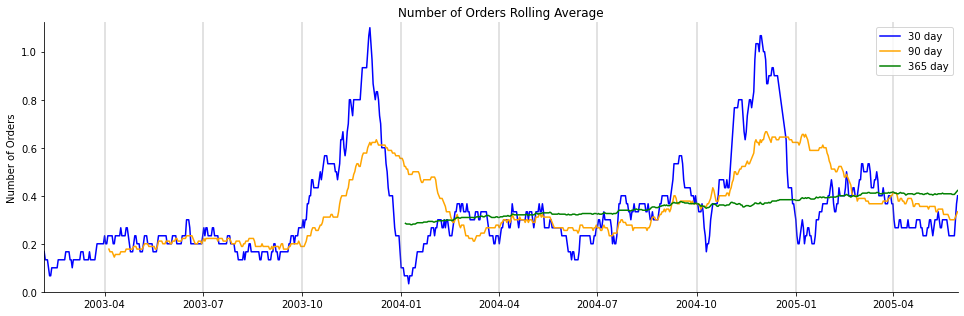

In [5]:
metric = 'orders'
labels_metric[metric] = 'Number of Orders'
plot_lines(metric, period_start=2)

The 30 day rolling average clearly follows a seasonal trend. The Q4 followed mostly the same patter in 2004 as it displayed in 2003. Q3 2004 and showed a very nice improvement year over year. I am assuming the company instituted marketing campaigns in Q1 & Q3 as there are local peaks in these quarters in 2004. Q2 still appears to be struggling. What is most promising is the general upward trend of the green 365 day rolling average line. Very positive signs to see it continually sloping up.

Seasonal sales trend, spiking in quarter 4, as is typical.

**Next steps are to build time series / auto-regressive models**
- ARIMA / SARIMA
- Multivariate auto regressive
- Recurrent neural networks with LSTM

Auto regressive models need to de-trend the data (normalize the slope) prior to making projections. LSTM techniques do not require de-trending and are significantly more powerful. However, given the small data set, a LSTM is more likely to overfit. Simpler models will probably generalize better in this specific situation.

### Percent change over time

The 90 day average is a little all over the place here, but a general trend down can be seen. These trend lines show the rate of change, year over year. The green 365 day average is effectively taking 2 years of data, rolling it forward. The rate of change is positive, but it is increasing at a decreasing rate. The orange 90 day average indicates that a downward trend during Q2 and into Q3 should be expected. However it is important to bring the slope of the line back to 0, thus showing consistent positive change, or ideally, get the line sloping in a positive direction.

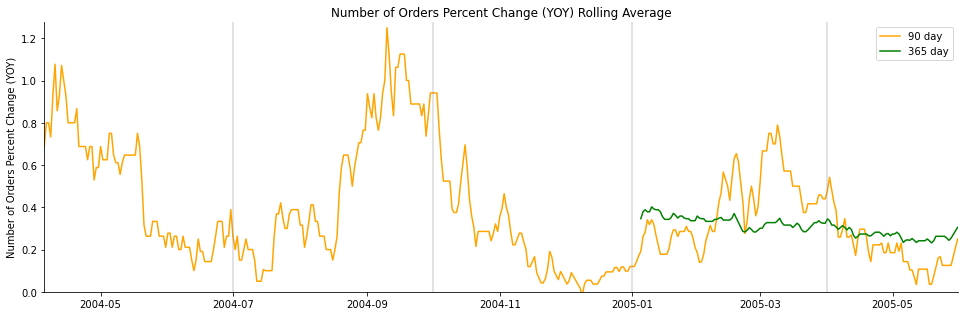

In [6]:
metric = 'orders_yoy'
labels_metric[metric] = 'Number of Orders Percent Change (YOY)'
plot_lines(metric, period_start=3)

### Monthly trends

Change in order volume by quarter.

In [7]:
# Convert month to quarter add year column
data_daily_roll = pd.merge(left=data_daily_roll, 
                           right=pd.DataFrame(
                               {'qtr': data_daily_roll.index.month.map(
                                       {1: 1, 2: 1, 3: 1,
                                        4: 2, 5: 2, 6: 2,
                                        7: 3, 8: 3, 9: 3,
                                        10: 4, 11: 4, 12: 4}),
                                'year': data_daily_roll.index.year,
                                                
                                        }, index=data_daily_roll.index),
                            how='left', left_index=True, right_index=True)

We only have enough data to look at 2003-2004 YOY gross sales as the data stops 2 months into Q2 2005. However, we can see a massive jump in YOY for both Q1 (87.3%) and Q3 (70.8%). Q2 had a very modest 10.3% change. Given the significant change in total sales in Q4, it is not overly surprising to see the percent change be fairly modest.

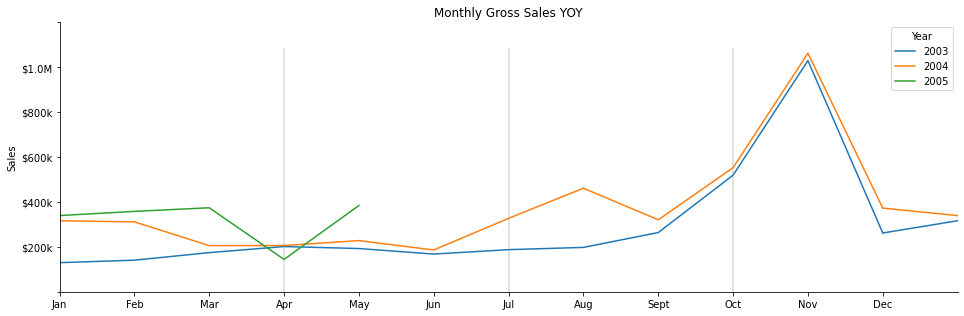

In [8]:
data_monthly = data[data['status'].isin(not_cancelled)].groupby(['year', 'month'])['adj_sales'].sum().reset_index(drop=False).astype(int)

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

# Instantiate Figure
plt.figure(figsize=(w, h))

# Draw lines
sns.lineplot(data=data_monthly, x='month', y='adj_sales', hue='year', 
             palette=sns.color_palette("tab10", len(data['year'].unique())))

# Dec-Jan Extension
# 2003
sns.lineplot(data=data_monthly[((data_monthly['year']==2003) & (data_monthly['month']==12)) | ((data_monthly['year']==2004) & (data_monthly['month']==1))],
             x=[12,13],
             y='adj_sales', color=sns.color_palette("tab10", 1).as_hex()[0])
# 2004
sns.lineplot(data=data_monthly[((data_monthly['year']==2004) & (data_monthly['month']==12)) | ((data_monthly['year']==2005) & (data_monthly['month']==1))],
             x=[12,13],
             y='adj_sales', color=sns.color_palette("tab10", 2).as_hex()[1])



# Add quarterly breaks
upper_bound = (data_monthly['adj_sales'].max() + data_monthly['adj_sales'].max() * .02)   # get maximum height + 2% of smallest period
plt.vlines(x=4, ymin=0, ymax=upper_bound, colors='gray', alpha=.3)
plt.vlines(x=7, ymin=0, ymax=upper_bound, colors='gray', alpha=.3)
plt.vlines(x=10, ymin=0, ymax=upper_bound, colors='gray', alpha=.3)


# Set Axis
plt.ylim(0, ((data_monthly['adj_sales'].max()//1000) + 10) * 1000)
plt.xlim(1, 13)
plt.xticks(ticks=list(range(1, 13)), labels=months)
plt.yticks(ticks=plt.gca().get_yticks(), labels=['', '$200k', '$400k', '$600k', '$800k', '$1.0M', ''])

# Label Chart
plt.ylabel('Sales')
plt.xlabel('')
plt.title('Monthly Gross Sales YOY')
plt.legend(title='Year')
plt.tight_layout()
sns.despine();

### Quarterly Trends

The trends identified in the section above this one are further highlighted. April, May, June (Q2) have very similar trend lines year over year.

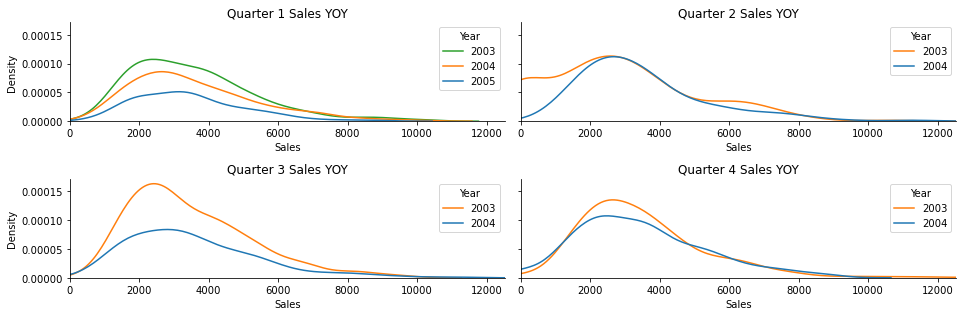

In [9]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(w, h), sharey=True)
qtr = 0
for ax in (ax1, ax2, ax3, ax4):
    qtr += 1
    if qtr == 2:
        sns.kdeplot(data=data[(data['qtr']==qtr) & (data['year'] != 2005)], x='adj_sales', hue='year', ax=ax, palette=sns.color_palette("tab10", 2))
    else:
        sns.kdeplot(data=data[data['qtr']==qtr], x='adj_sales', hue='year', ax=ax, palette=sns.color_palette("tab10", len(data[data['qtr']==qtr]['year'].unique())))    
    if qtr == 1:
        ax.legend(['2003', '2004', '2005'], title='Year')
        
    else:
        ax.legend(['2003', '2004'], title='Year')

    
    ax.set_xlabel('Sales')
    ax.set_xlim((0, max(data['adj_sales'])))
    ax.set_title(f'Quarter {qtr} Sales YOY')

plt.tight_layout()
sns.despine()

The changse are illustrated more drastically when aggregated by quarter. Q1, Q3, and Q4 all show positive changes year over year. Q2 on the other hand have had nearly identical distributions.

Year over year sales aggregated by quarter and stacked.

Quarterly Sales
year        2003        2004        2005
Q1     445094.69   833730.68  1071992.36
Q2     562365.22   620484.17   528699.83
Q3     649514.54  1109396.27         NaN
Q4    1811294.17  1988514.71         NaN

Change in Quarterly sales year over year
year  2003       2004       2005
Q1     NaN  388635.99  238261.68
Q2     NaN   58118.95  -91784.34
Q3     NaN  459881.73        NaN
Q4     NaN  177220.54        NaN

Percent Change
year  2003      2004      2005
Q1     NaN  0.873154  0.285778
Q2     NaN  0.103347 -0.147924
Q3     NaN  0.708039       NaN
Q4     NaN  0.097842       NaN


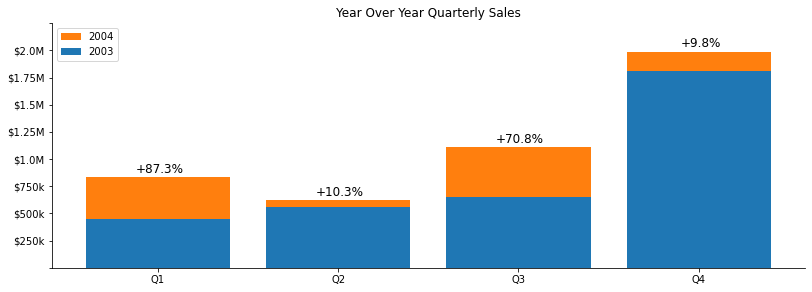

In [10]:
print('Quarterly Sales')
q1_change = pd.Series(data_daily_roll[data_daily_roll['qtr']==1].groupby('year')['adj_sales'].sum(), name='Q1')
q2_change = pd.Series(data_daily_roll[data_daily_roll['qtr']==2].groupby('year')['adj_sales'].sum(), name='Q2')
q3_change = pd.Series(data_daily_roll[data_daily_roll['qtr']==3].groupby('year')['adj_sales'].sum(), name='Q3')
q4_change = pd.Series(data_daily_roll[data_daily_roll['qtr']==4].groupby('year')['adj_sales'].sum(), name='Q4')
_ = pd.concat([q1_change, q2_change, q3_change, q4_change], axis=1).T
print(_)
print()
print('Change in Quarterly sales year over year')
print(_.diff(axis=1))
print()

fig, ax = plt.subplots(figsize=(w, h))

# # 2005
# ax.bar(x=['Q1', 'Q2', 'Q3', 'Q4'], height=[_.iloc[0][2005], 0, 0, 0], color=sns.color_palette("tab10", 3).as_hex()[2], label='2005')

# 2004
ax.bar(x=['Q1', 'Q2', 'Q3', 'Q4'], height=[_.iloc[0][2004], 0, 0, 0], color=sns.color_palette("tab10", 2).as_hex()[1], label='2004')
ax.bar(x=['Q1', 'Q2', 'Q3', 'Q4'], height=[0, _.iloc[1][2004],  0, 0], color=sns.color_palette("tab10", 2).as_hex()[1])
ax.bar(x=['Q1', 'Q2', 'Q3', 'Q4'], height=[0, 0, _.iloc[2][2004], 0], color=sns.color_palette("tab10", 2).as_hex()[1])
ax.bar(x=['Q1', 'Q2', 'Q3', 'Q4'], height=[0, 0, 0, _.iloc[3][2004]], color=sns.color_palette("tab10", 2).as_hex()[1])

# 2003
ax.bar(x=['Q1', 'Q2', 'Q3', 'Q4'], height=[_.iloc[0][2003], 0, 0, 0], color=sns.color_palette("tab10", 1).as_hex()[0], label='2003')
ax.bar(x=['Q1', 'Q2', 'Q3', 'Q4'], height=[0, _.iloc[1][2003],  0, 0], color=sns.color_palette("tab10", 1).as_hex()[0])
ax.bar(x=['Q1', 'Q2', 'Q3', 'Q4'], height=[0, 0, _.iloc[2][2003], 0], color=sns.color_palette("tab10", 1).as_hex()[0])
ax.bar(x=['Q1', 'Q2', 'Q3', 'Q4'], height=[0, 0, 0, _.iloc[3][2003]], color=sns.color_palette("tab10", 1).as_hex()[0])

# Pct Change
q1_change_pct = pd.Series(data_daily_roll[data_daily_roll['qtr']==1].groupby('year')['adj_sales'].sum().pct_change(), name='Q1')
q2_change_pct = pd.Series(data_daily_roll[data_daily_roll['qtr']==2].groupby('year')['adj_sales'].sum().pct_change(), name='Q2')
q3_change_pct = pd.Series(data_daily_roll[data_daily_roll['qtr']==3].groupby('year')['adj_sales'].sum().pct_change(), name='Q3')
q4_change_pct = pd.Series(data_daily_roll[data_daily_roll['qtr']==4].groupby('year')['adj_sales'].sum().pct_change(), name='Q4')

# Labels
#plt.annotate(f'+{np.round(q1_change_pct[2005]*100, 1)}%', xy=(-.125, int(_[2004][0] + 20000 + (_.diff(axis=1)[2004][0])) ), size=12)

plt.annotate(f'+{np.round(q1_change_pct[2004]*100, 1)}%', xy=(-.125, int(_[2003][0] + 40000 + (_.diff(axis=1)[2004][0])) ), size=12)
plt.annotate(f'+{np.round(q2_change_pct[2004]*100, 1)}%', xy=(0.875, int(_[2003][1] + 40000 + (_.diff(axis=1)[2004][1])) ), size=12)
plt.annotate(f'+{np.round(q3_change_pct[2004]*100, 1)}%', xy=(1.875, int(_[2003][2] + 40000 + (_.diff(axis=1)[2004][2])) ), size=12)
plt.annotate(f'+{np.round(q4_change_pct[2004]*100, 1)}%', xy=(2.9, int(_[2003][3] + 40000 + (_.diff(axis=1)[2004][3])) ), size=12)

# Chart labels
plt.legend()
plt.yticks(ticks=plt.gca().get_yticks(), labels=['', '$250k', '$500k', '$750k', '$1.0M', '$1.25M', '$1.5M', '$1.75M', '$2.0M', ''])
plt.title('Year Over Year Quarterly Sales')
sns.despine()

# 
print('Percent Change')
__ = pd.concat([q1_change_pct, q2_change_pct, q3_change_pct, q4_change_pct], axis=1).T
print(__)

# Show graph
plt.show()


## Profitable Products (Estimated)

Assumption: products with a larger Price to MSRP ratio likely have higher profit margins. 

It will be important to identify products the company profits the most when formulating a marketing strategy. This can provide a measure to guide the marketing team on advertising spend.

In [11]:
data[['price', 'msrp']].head()

,price,msrp
0,95.70,95
1,81.35,95
2,94.74,95
3,83.26,95
4,106.23,95


Calculate MSRP ratio.

In [12]:
data['msrp_ratio'] = data['price'] / data['msrp']
data[['msrp_ratio', 'price', 'msrp', 'quantity']].head(10)

,msrp_ratio,price,msrp,quantity
0,1.007368,95.70,95,30
1,0.856316,81.35,95,34
2,0.997263,94.74,95,41
3,0.876421,83.26,95,45
4,1.118211,106.23,95,49
5,1.017474,96.66,95,36
6,0.906632,86.13,95,29
7,1.208842,114.84,95,48
8,1.037579,98.57,95,22
9,1.208842,114.84,95,41


Inspect distribution of MSRP ratios.

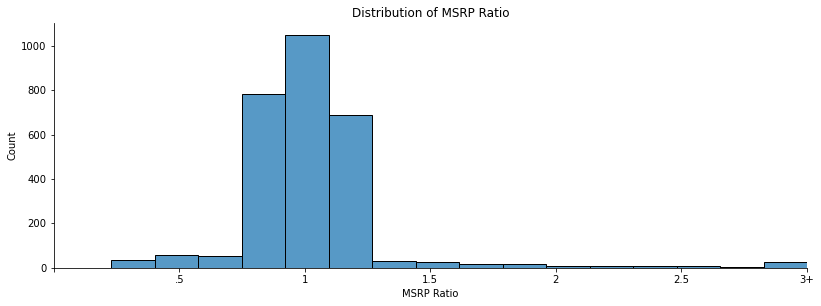

In [13]:
plt.figure(figsize=(w, h))
plt.title('Distribution of MSRP Ratio')
sns.histplot(data=data['msrp_ratio'].apply(lambda x: 3 if x >= 3 else x), bins=16)
plt.xlim((0, 3))
plt.xticks(ticks=plt.gca().get_xticks(), labels=['', '.5', '1', '1.5', '2', '2.5', '3+'])
plt.xlabel('MSRP Ratio')
sns.despine()

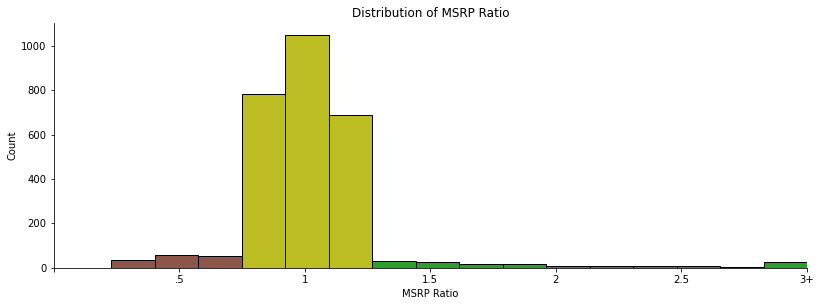

In [14]:
plt.figure(figsize=(w, h))
plt.title('Distribution of MSRP Ratio')
ax = sns.histplot(data=data['msrp_ratio'].apply(lambda x: 3 if x >= 3 else x), bins=16)
ax.patches[0].set_facecolor(sns.color_palette("tab10")[5])
ax.patches[1].set_facecolor(sns.color_palette("tab10")[5])
ax.patches[2].set_facecolor(sns.color_palette("tab10")[5])
ax.patches[3].set_facecolor(sns.color_palette("tab10")[-2])
ax.patches[4].set_facecolor(sns.color_palette("tab10")[-2])
ax.patches[5].set_facecolor(sns.color_palette("tab10")[-2])
ax.patches[6].set_facecolor(sns.color_palette("tab10")[2])
ax.patches[7].set_facecolor(sns.color_palette("tab10")[2])
ax.patches[8].set_facecolor(sns.color_palette("tab10")[2])
ax.patches[9].set_facecolor(sns.color_palette("tab10")[2])
ax.patches[10].set_facecolor(sns.color_palette("tab10")[2])
ax.patches[11].set_facecolor(sns.color_palette("tab10")[2])
ax.patches[12].set_facecolor(sns.color_palette("tab10")[2])
ax.patches[13].set_facecolor(sns.color_palette("tab10")[2])
ax.patches[14].set_facecolor(sns.color_palette("tab10")[2])
ax.patches[-1].set_facecolor(sns.color_palette("tab10")[2])

plt.xlim((0, 3))
plt.xticks(ticks=plt.gca().get_xticks(), labels=['', '.5', '1', '1.5', '2', '2.5', '3+'])
plt.xlabel('MSRP Ratio')
sns.despine()


Round to nearest half point.

In [15]:
(np.round(data['msrp_ratio'] * 2, 0)/2).value_counts().sort_index()

0.0       1
0.5     143
1.0    2520
1.5      73
2.0      36
2.5      25
3.0       7
3.5       8
4.0       5
4.5       2
5.0       1
6.0       1
7.5       1
Name: msrp_ratio, dtype: int64

Long right skewed tail to this distribution. Could be a sign of misreported data. If time was on my side, I would dig into this a little more. For now, I will lump the sales on the upper end into a "high margin" category.

In [16]:
(np.round(data['msrp_ratio'] * 2, 0)/2).apply(lambda x: 1.5 if x >= 1.5 else x).value_counts().sort_index()

0.0       1
0.5     143
1.0    2520
1.5     159
Name: msrp_ratio, dtype: int64

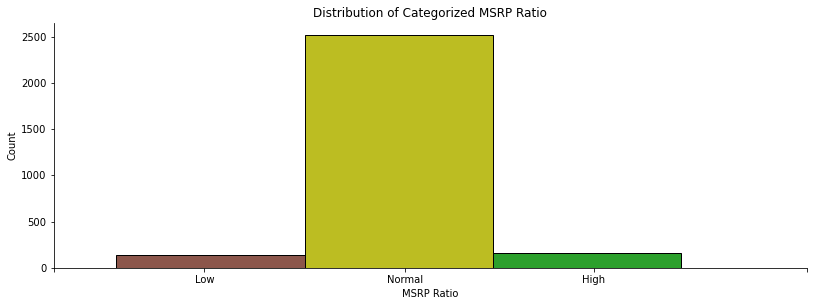

In [17]:
plt.figure(figsize=(w, h))
plt.title('Distribution of Categorized MSRP Ratio')
ax = sns.histplot((np.round(data['msrp_ratio'] * 2, 0)/2).apply(lambda x: 1.5 if x >= 1.5 else x), bins=4)
ax.patches[1].set_facecolor(sns.color_palette("tab10")[5])
ax.patches[2].set_facecolor(sns.color_palette("tab10")[-2])
ax.patches[3].set_facecolor(sns.color_palette("tab10")[2])
plt.xlim((.25, 1.75))
plt.xticks(ticks=[.25, .55, .95, 1.325, 1.75], labels=['', 'Low', 'Normal', 'High', ''])
plt.xlabel('MSRP Ratio')
sns.despine()


Classify

In [18]:
data['msrp_class'] = (np.round(data['msrp_ratio'] * 2, 0)/2).apply(lambda x: 1.5 if x >= 1.5 else x).replace({0.0: 'low', 0.5: 'low', 1.0: 'normal', 1.5: 'high'})
data['msrp_class']

0       normal
1       normal
2       normal
3       normal
4       normal
         ...  
2818      high
2819      high
2820      high
2821    normal
2822    normal
Name: msrp_class, Length: 2823, dtype: object

Sort products by highest average MSRP ratio

In [19]:
prod_ratio_mean = data.groupby('prod_code')['msrp_ratio'].mean().sort_values(ascending=False)
prod_ratio_mean.head(10)

prod_code
S24_1937    1.680448
S18_4668    1.557778
S24_2840    1.345959
S24_2972    1.344344
S50_1514    1.266625
S32_2206    1.251660
S32_3522    1.240660
S72_3212    1.236403
S24_2022    1.233318
S32_3207    1.214994
Name: msrp_ratio, dtype: float64

## Customer Analysis

### Sales by Territory and Product Line

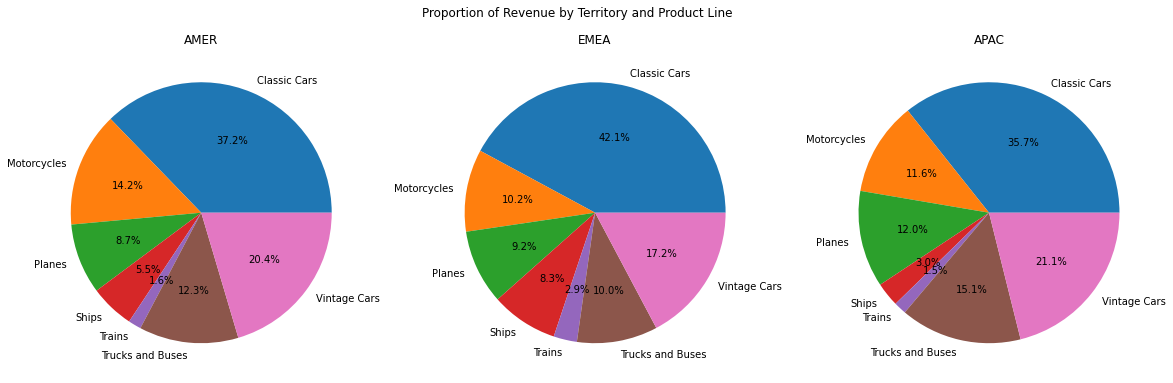

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
ters = data['territory'].unique()
ax1.pie(x=data[data['territory']==ters[0]].groupby('prod_line')['adj_sales'].sum().astype(int), labels=data[data['territory']==ters[0]].groupby('prod_line')['adj_sales'].sum().index, autopct='%1.1f%%');
ax1.set_title(ters[0])
ax2.pie(x=data[data['territory']==ters[1]].groupby('prod_line')['adj_sales'].sum().astype(int), labels=data[data['territory']==ters[1]].groupby('prod_line')['adj_sales'].sum().index, autopct='%1.1f%%');
ax2.set_title(ters[1])
ax3.pie(x=data[data['territory']==ters[2]].groupby('prod_line')['adj_sales'].sum().astype(int), labels=data[data['territory']==ters[2]].groupby('prod_line')['adj_sales'].sum().index, autopct='%1.1f%%');
ax3.set_title(ters[2])
fig.suptitle('Proportion of Revenue by Territory and Product Line')
plt.show();

With more time, I would bootstrap and ANOVA test these groups, but for now, will use the eye test. All 3 look very similar.

Next, it will be best to take a look at the distribution of the customers and analyze how frequently customers make a purchase.

### Customer order frequency

Products sales are fairly evently distributed across territory.

Merge confirmed orders adjusted sales volume with adjusted order volume, aggregated by customer name.

In [21]:
agg_comp = pd.merge(
    left=data[data['status'].isin(not_cancelled)].groupby(by=['customer']).sum()[['adj_sales']],                                            # calculate total sales per customer
    right=data[data['status'].isin(not_cancelled)].groupby(by=['customer', 'order']).count().groupby('customer').count()[['quantity']],     # calculate number of orders per customer
    
            left_index=True,
            right_index=True
            )


Add in territory

In [22]:
agg_comp = pd.merge(left=agg_comp, right=data.groupby('customer')['territory'].first(), left_index=True, right_index=True)

In [23]:
agg_comp.sort_values(by='quantity', ascending=False, inplace=True)
agg_comp.rename({'quantity': 'num_orders'}, axis=1, inplace=True)
agg_comp['adj_sales'] = agg_comp['adj_sales'].astype(int)
agg_comp

,adj_sales,num_orders,territory
customer,,,
Euro Shopping Channel,845894,25,EMEA
Mini Gifts Distributors Ltd.,654759,17,AMER
Reims Collectables,135042,5,EMEA
"Dragon Souveniers, Ltd.",172989,5,APAC
"Australian Collectors, Co.",200995,5,APAC
...,...,...,...
Collectable Mini Designs Co.,87489,2,AMER
"Clover Collections, Co.",57756,2,EMEA
"Iberia Gift Imports, Corp.",54723,2,EMEA


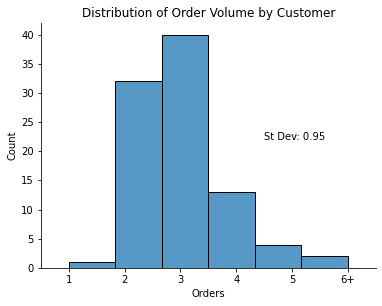

In [24]:
plt.figure(figsize=(int(w/2), h))
plt.title('Distribution of Order Volume by Customer')
sns.histplot(data=agg_comp['num_orders'].map(lambda x: 6 if x > 5 else x), bins=6)
plt.annotate(f'St Dev: {np.round(np.std(agg_comp["num_orders"].map(lambda x: 6 if x > 5 else x), ddof=1), 2)}', (4.5, 22))
plt.xlabel('Orders')
plt.xticks(ticks=list(range(8)), labels=['0', '1', '2', '3', '4', '5', '6+', ''])
plt.xlim((.5, 6.5))
sns.despine()
plt.show()

We can see a normal-ish distribution of order volumn by customer if we lump high volume customers into one bin. In this case, I used customers with 6 or more orders.

In [25]:
agg_comp['num_orders'].value_counts().sort_index()

1      1
2     32
3     40
4     13
5      4
17     1
25     1
Name: num_orders, dtype: int64

Calculate customer average order size

In [26]:
agg_comp['avg_order'] = (agg_comp['adj_sales'] / agg_comp['num_orders'])

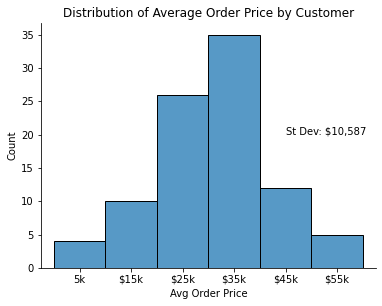

In [27]:
plt.figure(figsize=(int(w/2), h))
plt.title('Distribution of Average Order Price by Customer')
sns.histplot(data=agg_comp['avg_order'], bins=list(range(0, 80000, 10000)))
plt.annotate(f'St Dev: {add_commas(int(np.std(agg_comp["avg_order"], ddof=1)), currency=True)}', (45000, 20))
plt.xlabel('Avg Order Price')
plt.xticks(ticks=list(range(-5000, 75000, 10000)), labels=['', '5k', '$15k', '$25k', '$35k', '$45k', '$55k', ''])
plt.xlim((-2500, 62500))
sns.despine()
plt.show()

Order size (in $) is also mostly normally distributed. Its safe to say where the orders originate, how often a customer purchases, and the size of the order are all mostly normally distributed.

In [28]:
agg_comp['avg_order'].min()

4564.5

In [29]:
agg_comp['avg_order'].max()

58856.5

Majority of customers are low volume. A potential avenue of increasing sales is to recapture existing customers. A promotion could be developed to help market new/different products to past customers based on buying patterns of high volume customers.

In [30]:
agg_comp['num_orders'][:40]

customer
Euro Shopping Channel           25
Mini Gifts Distributors Ltd.    17
Reims Collectables               5
Dragon Souveniers, Ltd.          5
Australian Collectors, Co.       5
Danish Wholesale Imports         5
Souveniers And Things Co.        4
Handji Gifts& Co                 4
Muscle Machine Inc               4
Diecast Classics Inc.            4
Corporate Gift Ideas Co.         4
Royale Belge                     4
Salzburg Collectables            4
La Rochelle Gifts                4
Tokyo Collectables, Ltd          4
Baane Mini Imports               4
Technics Stores Inc.             4
Anna's Decorations, Ltd          4
Blauer See Auto, Co.             4
Motor Mint Distributors Inc.     3
Land of Toys Inc.                3
Alpha Cognac                     3
Marseille Mini Autos             3
Volvo Model Replicas, Co         3
Mini Auto Werke                  3
Mini Caravy                      3
Mini Creations Ltd.              3
Vitachrome Inc.                  3
Mini Wheels

Estimate proportion of customers aggregated by order volume

In [31]:
agg_comp['num_orders'].value_counts(normalize=True).sort_index()

1     0.010870
2     0.347826
3     0.434783
4     0.141304
5     0.043478
17    0.010870
25    0.010870
Name: num_orders, dtype: float64

In [32]:
agg_comp['num_orders'].value_counts(normalize=True).sort_index().loc[[1, 2, 3]].sum()

0.7934782608695652

In [33]:
agg_comp['num_orders'].value_counts(normalize=True).sort_index().loc[[4, 5, 17, 25]].sum()

0.20652173913043476

Customers location, frequency of order, and order size are all mostly normally distributed. Ideal for modeling/predicting customer behavior.

## Recommender

The goal of the recommender is to identify product similarity based pre-defined criteria. It is important to capture profitability, location, volume, and product features in the model. The features I have chosen to explore in an attempt to capture the above listed metrics are:
| Metric | Feature |
| ------ | ------- |
| Profitability | msrp_class |
| Location | territory |
| Volume | size |
| Product | prod_line |

In [34]:
cols_rec = ['prod_code', 'msrp_class', 'territory', 'size', 'prod_line']

In [35]:
rec_data = data[cols_rec]
rec_data.sample(10)

,prod_code,msrp_class,territory,size,prod_line
1586,S24_2000,high,EMEA,Small,Motorcycles
2172,S32_1268,normal,EMEA,Medium,Trucks and Buses
258,S12_2823,normal,AMER,Medium,Motorcycles
2757,S700_4002,normal,EMEA,Small,Planes
1876,S24_3371,normal,EMEA,Small,Classic Cars
1541,S24_1937,normal,AMER,Small,Vintage Cars
1408,S18_4933,normal,EMEA,Small,Classic Cars
441,S18_1097,low,APAC,Small,Trucks and Buses
2085,S24_4258,normal,AMER,Medium,Vintage Cars
1894,S24_3420,normal,EMEA,Small,Vintage Cars


Will use a count vectorizor to weight in the frequency of each feature for each observation.

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

### MSRP

In [37]:
msrp_data = rec_data.groupby('prod_code')['msrp_class'].apply(list).apply(lambda x: ' '.join(x))
msrp_data.sample(10)

prod_code
S24_2972     normal normal normal normal normal normal norm...
S12_1666     normal normal normal normal normal normal norm...
S18_2432     normal normal normal normal normal normal norm...
S18_4668     normal normal normal normal normal normal norm...
S12_4473     normal normal normal normal normal normal norm...
S18_4721     normal normal normal normal normal normal norm...
S18_2581     normal normal normal normal normal normal norm...
S18_3482     normal normal normal normal normal normal norm...
S700_1138    normal normal normal normal normal normal norm...
S50_4713     normal normal normal normal normal normal norm...
Name: msrp_class, dtype: object

In [38]:
tf_msrp = TfidfVectorizer(min_df=0, vocabulary=['low', 'normal', 'high'])

In [39]:
msrp_data_tf = tf_msrp.fit_transform(msrp_data)

In [40]:
msrp_data_tf = pd.DataFrame(msrp_data_tf.A, columns=tf_msrp.get_feature_names_out(), index=msrp_data.index)
msrp_data_tf = msrp_data_tf.add_prefix('msrp_')
msrp_data_tf.sample(10)

,msrp_low,msrp_normal,msrp_high
prod_code,,,
S18_2795,0.268430,0.961049,0.065800
S700_2047,0.056310,0.998413,0.000000
S24_3151,0.060876,0.996359,0.059690
S18_3140,0.126487,0.991968,0.000000
S50_1341,0.000000,0.967487,0.252919
S12_3148,0.269013,0.963137,0.000000
S700_3167,0.000000,0.981316,0.192401
S12_3990,0.000000,0.998210,0.059801
S72_1253,0.000000,0.950537,0.310610


### Location

In [41]:
location_data = rec_data.groupby('prod_code')['territory'].apply(list).apply(lambda x: ' '.join(x))
location_data.sample(10)

prod_code
S12_3990    APAC EMEA AMER AMER AMER APAC EMEA EMEA EMEA E...
S32_1268    EMEA EMEA EMEA AMER EMEA EMEA EMEA EMEA EMEA A...
S18_2581    EMEA APAC EMEA AMER AMER APAC APAC AMER AMER A...
S24_1628    EMEA EMEA EMEA APAC EMEA AMER EMEA AMER AMER E...
S12_1666    EMEA AMER EMEA AMER APAC EMEA APAC AMER EMEA A...
S24_3191    EMEA AMER APAC EMEA AMER AMER AMER AMER EMEA E...
S24_2887    EMEA AMER APAC EMEA EMEA AMER AMER AMER EMEA E...
S12_1108    EMEA APAC AMER AMER EMEA APAC EMEA AMER AMER E...
S18_3685    AMER EMEA EMEA APAC EMEA AMER EMEA AMER AMER E...
S18_4668    EMEA AMER EMEA AMER APAC EMEA APAC AMER EMEA A...
Name: territory, dtype: object

In [42]:
tf_location = TfidfVectorizer(min_df=0, vocabulary=['amer', 'emea', 'apac'])

In [43]:
location_data_tf = tf_location.fit_transform(location_data)

In [44]:
location_data_tf = pd.DataFrame(location_data_tf.A, columns=tf_location.get_feature_names_out(), index=location_data.index)
location_data_tf = location_data_tf.add_prefix('loc_')
location_data_tf.sample(10)

,loc_amer,loc_emea,loc_apac
prod_code,,,
S700_2047,0.572125,0.800975,0.176384
S24_2972,0.590463,0.805177,0.055163
S32_1268,0.695720,0.695720,0.178739
S18_2625,0.807155,0.496711,0.319028
S24_2887,0.573621,0.788729,0.221056
S700_2466,0.524983,0.816640,0.239777
S24_2840,0.702729,0.702729,0.111102
S18_3278,0.456730,0.848212,0.268205
S24_4620,0.492157,0.861275,0.126441


### Volume

In [45]:
volume_data = rec_data.groupby('prod_code')['size'].apply(list).apply(lambda x: ' '.join(x))
volume_data.sample(10)

prod_code
S18_1097     Medium Medium Medium Medium Medium Medium Medi...
S32_4485     Medium Small Small Medium Small Medium Small M...
S18_4721     Medium Medium Medium Medium Medium Medium Medi...
S50_1514     Small Small Medium Small Small Small Small Sma...
S18_1662     Medium Medium Small Medium Medium Medium Mediu...
S700_1138    Small Small Small Small Small Medium Small Sma...
S24_2360     Small Small Small Small Small Small Small Medi...
S18_3685     Medium Medium Medium Medium Medium Medium Medi...
S24_2887     Medium Small Medium Small Small Small Medium M...
S32_3207     Medium Small Small Medium Small Small Small Sm...
Name: size, dtype: object

In [46]:
tf_volume = TfidfVectorizer(min_df=0, vocabulary=['small', 'medium', 'large'])

In [47]:
volume_data_tf = tf_volume.fit_transform(volume_data)

In [48]:
volume_data_tf = pd.DataFrame(volume_data_tf.A, columns=tf_volume.get_feature_names_out(), index=volume_data.index)
volume_data_tf = volume_data_tf.add_prefix('vol_')
volume_data_tf.sample(10)

,vol_small,vol_medium,vol_large
prod_code,,,
S32_4289,0.894427,0.447214,0.000000
S12_3990,0.932005,0.362446,0.000000
S18_4721,0.097930,0.979304,0.177123
S10_4962,0.127794,0.979757,0.154091
S18_3140,0.242536,0.970143,0.000000
S18_3029,0.806405,0.591364,0.000000
S18_2870,0.195350,0.976748,0.088330
S12_4675,0.487899,0.867376,0.098049
S24_1444,0.997054,0.076696,0.000000


### Product

In [49]:
product_data = rec_data.groupby('prod_code')['prod_line'].apply(list).apply(lambda x: ' '.join(x))
product_data

prod_code
S10_1678     Motorcycles Motorcycles Motorcycles Motorcycle...
S10_1949     Classic Cars Classic Cars Classic Cars Classic...
S10_2016     Motorcycles Motorcycles Motorcycles Motorcycle...
S10_4698     Motorcycles Motorcycles Motorcycles Motorcycle...
S10_4757     Classic Cars Classic Cars Classic Cars Classic...
                                   ...                        
S700_3505    Ships Ships Ships Ships Ships Ships Ships Ship...
S700_3962    Ships Ships Ships Ships Ships Ships Ships Ship...
S700_4002    Planes Planes Planes Planes Planes Planes Plan...
S72_1253     Planes Planes Planes Planes Planes Planes Plan...
S72_3212     Ships Ships Ships Ships Ships Ships Ships Ship...
Name: prod_line, Length: 109, dtype: object

In [50]:
product_vocab = pd.Series(data['prod_line'].unique()).str.lower().to_list()
product_vocab

['motorcycles',
 'classic cars',
 'trucks and buses',
 'vintage cars',
 'planes',
 'ships',
 'trains']

In [51]:
tf_product = TfidfVectorizer(min_df=0, vocabulary=product_vocab)

In [52]:
product_data_tf = tf_product.fit_transform(product_data)

In [53]:
product_data_tf = pd.DataFrame(product_data_tf.A, columns=tf_product.get_feature_names_out(), index=product_data.index)
product_data_tf = product_data_tf.add_prefix('prod_')
product_data_tf

,prod_motorcycles,prod_classic cars,prod_trucks and buses,prod_vintage cars,prod_planes,prod_ships,prod_trains
prod_code,,,,,,,
S10_1678,1.0,0.0,0.0,0.0,0.0,0.0,0.0
S10_1949,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S10_2016,1.0,0.0,0.0,0.0,0.0,0.0,0.0
S10_4698,1.0,0.0,0.0,0.0,0.0,0.0,0.0
S10_4757,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
S700_3505,0.0,0.0,0.0,0.0,0.0,1.0,0.0
S700_3962,0.0,0.0,0.0,0.0,0.0,1.0,0.0
S700_4002,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Aggregate Term Frequencies

In [54]:
tf_data = pd.merge(left=msrp_data_tf, right=location_data_tf, left_index=True, right_index=True)
tf_data = pd.merge(left=tf_data, right=volume_data_tf, left_index=True, right_index=True)
tf_data = pd.merge(left=tf_data, right=product_data_tf, left_index=True, right_index=True)
tf_data

,msrp_low,msrp_normal,msrp_high,loc_amer,loc_emea,loc_apac,vol_small,vol_medium,vol_large,prod_motorcycles,prod_classic cars,prod_trucks and buses,prod_vintage cars,prod_planes,prod_ships,prod_trains
prod_code,,,,,,,,,,,,,,,,
S10_1678,0.060876,0.996359,0.059690,0.701977,0.701977,0.120231,0.503836,0.839727,0.202504,1.0,0.0,0.0,0.0,0.0,0.0,0.0
S10_1949,0.303718,0.952762,0.000000,0.810973,0.463413,0.357170,0.035111,0.456445,0.889058,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S10_2016,0.195677,0.978581,0.063955,0.812471,0.437484,0.385355,0.287348,0.957826,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
S10_4698,0.121296,0.992616,0.000000,0.849810,0.424905,0.311896,0.080383,0.482297,0.872312,1.0,0.0,0.0,0.0,0.0,0.0,0.0
S10_4757,0.247113,0.968987,0.000000,0.624695,0.780869,0.000000,0.356251,0.916075,0.184096,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S700_3505,0.000000,1.000000,0.000000,0.467888,0.883788,0.000000,0.467888,0.883788,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0
S700_3962,0.058554,0.998284,0.000000,0.489495,0.870213,0.055892,0.707107,0.707107,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0
S700_4002,0.000000,0.998474,0.055216,0.524983,0.816640,0.239777,0.894427,0.447214,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Similarity Matrix

In [55]:
from sklearn.metrics.pairwise import cosine_similarity

In [56]:
similarity_matrix = cosine_similarity(tf_data)
recommender_df = pd.DataFrame(similarity_matrix, index=tf_data.index, columns=tf_data.index, dtype=np.float16)

In [57]:
recommender_df

prod_code,S10_1678,S10_1949,S10_2016,S10_4698,S10_4757,S10_4962,S12_1099,S12_1108,S12_1666,S12_2823,...,S700_2466,S700_2610,S700_2824,S700_2834,S700_3167,S700_3505,S700_3962,S700_4002,S72_1253,S72_3212
prod_code,,,,,,,,,,,,,,,,,,,,,
S10_1678,1.000000,0.717773,0.965820,0.887695,0.852539,0.822266,0.772461,0.690430,0.830078,0.964844,...,0.739258,0.711914,0.857422,0.742188,0.729980,0.730957,0.727539,0.698730,0.632324,0.656250
S10_1949,0.717773,1.000000,0.704102,0.859863,0.820312,0.856445,0.873047,0.937500,0.854980,0.777832,...,0.668457,0.598145,0.804688,0.742188,0.652344,0.624023,0.616699,0.599609,0.549805,0.533691
S10_2016,0.965820,0.704102,1.000000,0.869141,0.815430,0.854980,0.698242,0.610352,0.859863,0.950684,...,0.698242,0.641602,0.840332,0.733887,0.679688,0.681641,0.666992,0.635742,0.556641,0.564453
S10_4698,0.887695,0.859863,0.869141,1.000000,0.717285,0.748535,0.744629,0.791504,0.752441,0.936523,...,0.594727,0.537598,0.712891,0.650879,0.580566,0.557617,0.549805,0.536621,0.494141,0.479248
S10_4757,0.852539,0.820312,0.815430,0.717285,1.000000,0.947266,0.922852,0.817871,0.942383,0.831055,...,0.836426,0.791992,0.976074,0.851562,0.814941,0.845215,0.827637,0.768066,0.673340,0.719238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S700_3505,0.730957,0.624023,0.681641,0.557617,0.845215,0.787109,0.764648,0.636230,0.785156,0.684082,...,0.737793,0.962891,0.840820,0.715820,0.723633,1.000000,0.988281,0.694824,0.612305,0.911621
S700_3962,0.727539,0.616699,0.666992,0.549805,0.827637,0.757812,0.746582,0.640625,0.763184,0.649902,...,0.740723,0.990723,0.828125,0.707520,0.737793,0.988281,1.000000,0.731445,0.671387,0.955566
S700_4002,0.698730,0.599609,0.635742,0.536621,0.768066,0.709961,0.691406,0.616699,0.727051,0.593750,...,0.971191,0.744141,0.792480,0.924805,0.983398,0.694824,0.731445,1.000000,0.970703,0.730469


### Make recommendation

In [58]:
def make_rec(product: str, quiet=False) -> pd.DataFrame:
    """Returns 10 most profitable products of 15 most similar products to target. Orders by weghted MSRP ratio."""
    if product in recommender_df.index:
        # Filter 15 most similar items
        rec = recommender_df.loc[product].sort_values(ascending=False)[1:16]

        # Get Product Line label for recommended products
        prods = data[data['prod_code'].isin(rec.index)].groupby('prod_code')['prod_line'].first()

        # Merge recommendations with Product Line label
        rec = pd.merge(left=rec, right=prods, left_index=True, right_index=True)

        # Calculate mean MSRP Ratio for recommended Products
        _ = data[data['prod_code'].isin(rec.index)][['prod_code', 'price', 'quantity', 'msrp']].set_index('prod_code')
        _['p_wei'] = _['price'] * _['quantity'] # price * quantity
        _['m_wei'] = _['msrp'] * _['quantity']  # msrp * quantity

        w = data[data['prod_code'].isin(rec.index)].groupby('prod_code').count()['order']   # number of observations

        _['p_wei'] = _['p_wei'] / w     # avg weighted price
        _['m_wei'] = _['m_wei'] / w     # avg weighted msrp

        _['r_wei'] = _['p_wei'] / _['m_wei']    # non-aggregated weighted MSRP ratio

        msrp_ratio = _.groupby('prod_code').mean()['r_wei'] # aggregated ratio

        # Add MSRP ratio to output data
        rec = pd.merge(left=rec, right=msrp_ratio, left_index=True, right_index=True)

        # Get Product Line label for target Product
        prod_line = data.loc[data['prod_code']==product, 'prod_line'].values[0]

        # Reorder & reformat for export
        rec.sort_values(by=['r_wei'], ascending=False, inplace=True)
        rec.reset_index(inplace=True)
        rec.rename({'prod_line': 'Product Line', 'r_wei': 'MSRP Ratio', 'prod_code': 'Recommendation'}, axis=1, inplace=True)
        rec.set_index('Recommendation', inplace=True)

        # Print Display
        if not quiet:
            print(f'Product ID Entered: {product}')
            print(f'Product Line: {prod_line}')
            print('Recommendations:')

        return rec.head(10)
    else:
        return 'Invalid product ID'

Tests:

In [59]:
make_rec('S10_1678')

Product ID Entered: S10_1678
Product Line: Motorcycles
Recommendations:


,S10_1678,Product Line,MSRP Ratio
Recommendation,,,
S32_2206,0.898438,Motorcycles,1.251660
S50_4713,0.976562,Motorcycles,1.155630
S18_2625,0.889648,Motorcycles,1.089083
S24_2000,0.966309,Motorcycles,1.089018
S18_3782,0.901367,Motorcycles,1.083419
S18_3320,0.862305,Vintage Cars,1.071585
S24_2360,0.917480,Motorcycles,1.054104
S32_4485,0.993164,Motorcycles,1.052302
S24_3151,0.863281,Vintage Cars,1.038733


In [60]:
make_rec('S10_1949', quiet=True)

,S10_1949,Product Line,MSRP Ratio
Recommendation,,,
S18_3320,0.839844,Vintage Cars,1.071585
S12_1666,0.854980,Trucks and Buses,1.026985
S18_2325,0.842773,Vintage Cars,1.018907
S18_4027,0.893555,Classic Cars,1.010734
S18_2238,0.972168,Classic Cars,0.972536
S10_4698,0.859863,Motorcycles,0.965187
S18_3232,0.912598,Classic Cars,0.956985
S10_4962,0.856445,Classic Cars,0.945848
S12_3148,0.879395,Classic Cars,0.932675


In [61]:
make_rec('S700_3505')

Product ID Entered: S700_3505
Product Line: Ships
Recommendations:


,S700_3505,Product Line,MSRP Ratio
Recommendation,,,
S72_3212,0.911621,Ships,1.236403
S700_1938,0.986816,Ships,1.099247
S700_1138,0.898438,Ships,1.088543
S18_1889,0.857910,Classic Cars,1.078012
S700_2610,0.962891,Ships,1.048392
S700_2047,0.972656,Ships,1.032169
S18_4522,0.861816,Vintage Cars,1.026026
S24_4048,0.860352,Classic Cars,0.994769
S50_1392,0.855469,Trucks and Buses,0.976832


**Recommender is able to isolate a product existing customers are likely to also be interested in. These products are ordered by profitability, under the assumption as Price / MSRP increases, so too does Profitability.**

In [62]:
data[data['prod_code']=='S700_3505']['size'].value_counts()

Medium    17
Small      9
Name: size, dtype: int64

In [63]:
data[data['prod_code']=='S700_3505']['territory'].value_counts()

EMEA    17
AMER     9
Name: territory, dtype: int64

In [64]:
data[data['prod_code']=='S700_3505']['msrp_class'].value_counts()

normal    26
Name: msrp_class, dtype: int64

Example: Similar Product

In [65]:
data[data['prod_code']=='S700_1938']['size'].value_counts()

Medium    13
Small     12
Name: size, dtype: int64

In [66]:
data[data['prod_code']=='S700_1938']['territory'].value_counts()

EMEA    14
AMER     9
APAC     2
Name: territory, dtype: int64

In [67]:
data[data['prod_code']=='S700_1938']['msrp_class'].value_counts()

normal    23
high       2
Name: msrp_class, dtype: int64

# Marketing Strategy

The marketing strategy will be a 3 step approach. 
1) Identify the target customers. 
2) Identify the best time of year to run the promotion.
3) Identify products to market.

## Target Customers

Step 1. Identify the target customers.

If the two largest repeat customers are clipped from the data, the standard deviation normalizes a bit. Given the small data set, I think this is the best avenue for summarizing.

In [68]:
print(f"Adjusted sample mean: {np.round(agg_comp['num_orders'].map(lambda x: 6 if x > 5 else x).mean(), 2)}")
print(f"Adjusted sample std dev: {np.round(np.std(agg_comp['num_orders'].map(lambda x: 6 if x > 5 else x), ddof=1), 2)}")   # std of sample

Adjusted sample mean: 2.92
Adjusted sample std dev: 0.95


With a mean of 2.9 and a standard deviation of .95, 78% of customers fall within 2 and 4 orders. Under the assumption that "all customers" cannot be advertised to efficiently, the new marketing campaign will target existing customers who have previously made exactly 3 orders.. This segment is a little more than 1/2 standard deviation on either side of the mean and is also the mode containing 35% of existing customers. Investing ad spend on customers with a low transaction history is likely to have a lower CTR than on customers who already purchase products more frequently. Targeting repeat customers will likely be more cost effective than searching for new customers in the company's existing markets.

In [69]:
agg_comp['num_orders'].value_counts().sort_index()

1      1
2     32
3     40
4     13
5      4
17     1
25     1
Name: num_orders, dtype: int64

In [70]:
print(f"Average order price is {add_commas(agg_comp['avg_order'].mean(), currency=True)} with a standard deviation of {add_commas(np.std(agg_comp['avg_order'], ddof=1), currency=True)}")

Average order price is $31,834 with a standard deviation of $10,587


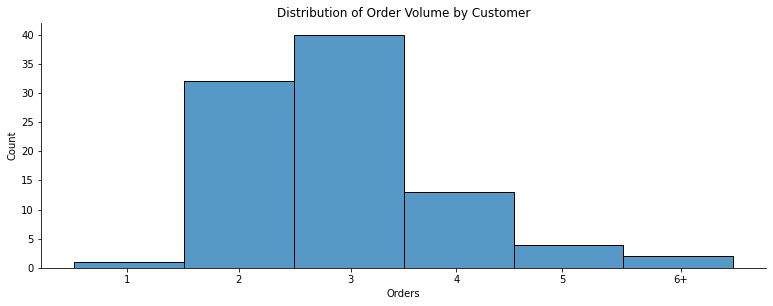

In [71]:
heights = agg_comp['num_orders'].map(lambda x: 6 if x > 5 else x).value_counts().sort_index()

plt.figure(figsize=(int(w), h))
plt.title('Distribution of Order Volume by Customer')
ax = sns.histplot(data=agg_comp['num_orders'].map(lambda x: 6 if x > 5 else x), bins=6)
plt.xlabel('Orders')
plt.xticks(ticks=[0.25, 1.4, 2.25, 3.1, 3.9, 4.7, 5.6, 7.25], labels=['0', '1', '2', '3', '4', '5', '6+', ''])
plt.xlim((0.75, 6.25))
plt.ylim((0, heights.max()+2))
sns.despine()
plt.show()

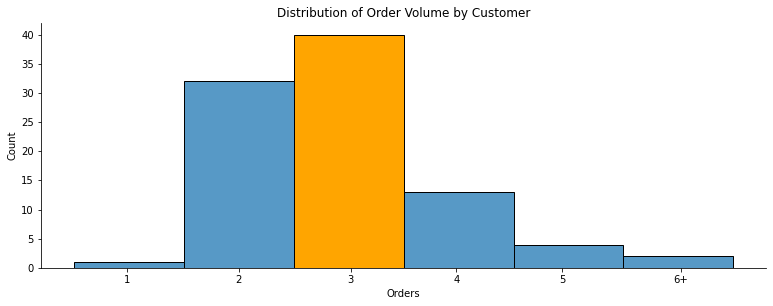

In [72]:
plt.figure(figsize=(int(w), h))
plt.title('Distribution of Order Volume by Customer')
ax = sns.histplot(data=agg_comp['num_orders'].map(lambda x: 6 if x > 5 else x), bins=6)
ax.patches[2].set_facecolor('orange')
plt.xlabel('Orders')
plt.xticks(ticks=[0.25, 1.4, 2.25, 3.1, 3.9, 4.7, 5.6, 7.25], labels=['0', '1', '2', '3', '4', '5', '6+', ''])
plt.xlim((0.75, 6.25))
plt.ylim((0, heights.max()+2))
sns.despine()
plt.show()


In [73]:
pd.concat([agg_comp.groupby('num_orders')['avg_order'].mean(), agg_comp.groupby('num_orders')['adj_sales'].sum()], axis=1).astype(int)

,avg_order,adj_sales
num_orders,,
1,34993,34993
2,33099,2118391
3,30249,3629924
4,32615,1696020
5,32053,641061
17,38515,654759
25,33835,845894


## Campaign Window

2) Identify the best time of year to run the promotion.

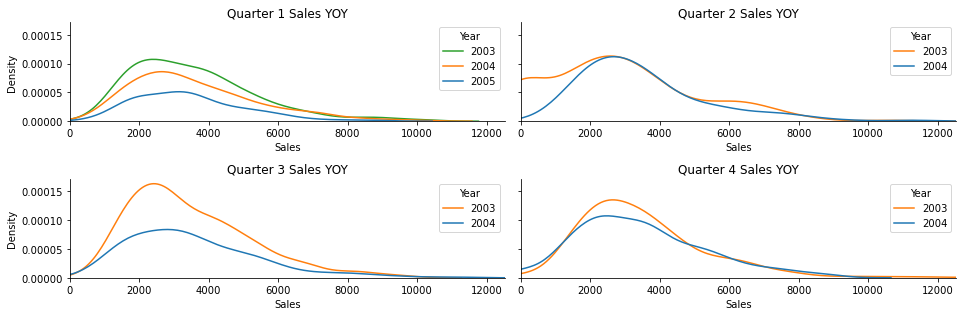

In [74]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(w, h), sharey=True)
qtr = 0
for ax in (ax1, ax2, ax3, ax4):
    qtr += 1
    if qtr == 2:
        sns.kdeplot(data=data[(data['qtr']==qtr) & (data['year'] != 2005)], x='adj_sales', hue='year', ax=ax, palette=sns.color_palette("tab10", 2))
    else:
        sns.kdeplot(data=data[data['qtr']==qtr], x='adj_sales', hue='year', ax=ax, palette=sns.color_palette("tab10", len(data[data['qtr']==qtr]['year'].unique())))    
    if qtr == 1:
        ax.legend(['2003', '2004', '2005'], title='Year')
        
    else:
        ax.legend(['2003', '2004'], title='Year')

    
    ax.set_xlabel('Sales')
    ax.set_xlim((0, max(data['adj_sales'])))
    ax.set_title(f'Quarter {qtr} Sales YOY')

plt.tight_layout()
sns.despine()

Consistently seeing the least amount of growth in Q2

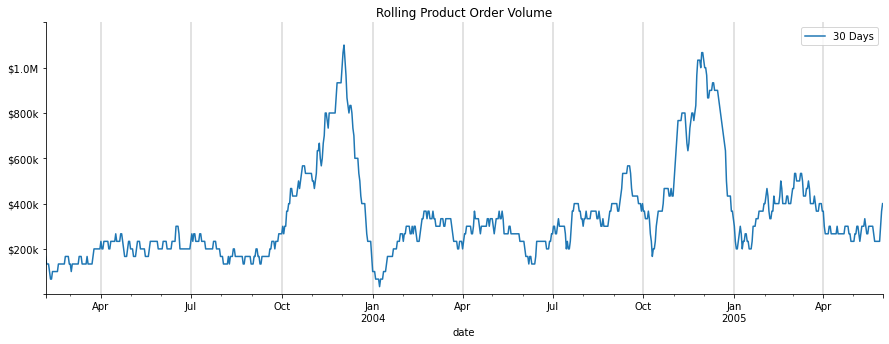

In [75]:
upper_bound_order = data_daily_roll['orders'].rolling(30, min_periods=0).mean().max() + .1

plt.figure(figsize=[15, 5])
plt.title('Rolling Product Order Volume')
plt.axis([data_daily_roll['orders'].rolling(30, min_periods=1).mean().index.min(), data_daily_roll.index.max(), 0, upper_bound_order])

dates_2003 = data_daily_roll.index[data_daily_roll.index.isin(pd.date_range(start='2003-04-01', end='2003-7-31'))]
dates_2004 = data_daily_roll.index[data_daily_roll.index.isin(pd.date_range(start='2004-04-01', end='2004-7-31'))]
dates_2005 = data_daily_roll.index[data_daily_roll.index.isin(pd.date_range(start='2005-04-01', end='2005-7-31'))]

# Quarters
new_date = pd.to_datetime('2003-4-1')
while new_date < data_daily_roll.index.max():
    plt.vlines(x=new_date, ymin=0, ymax=upper_bound_order, colors='gray', alpha=.3)
    new_date += pd.DateOffset(months=3)

# Rolling averages
data_daily_roll['orders'].rolling(30).mean().plot(label='30 Days')

# Yearly order peaks
# plt.vlines(x=data_daily_roll.rolling(30).mean().loc[dates_2003, 'orders'].idxmin(), ymin=0, ymax=upper_bound_order, colors='red', alpha=.5, label='Q2 Lows')
# plt.vlines(x=data_daily_roll.rolling(30).mean().loc[dates_2004, 'orders'].idxmin(), ymin=0, ymax=upper_bound_order, colors='red', alpha=.5)
# plt.vlines(x=data_daily_roll.rolling(30).mean().loc[dates_2005, 'orders'].idxmin(), ymin=0, ymax=upper_bound_order, colors='red', alpha=.5)
plt.xlim([data_daily_roll.index[data_daily_roll['orders'].rolling(30).mean().notnull()].min(), data_daily_roll.index.max()])
plt.yticks(ticks=plt.gca().get_yticks(), labels=['', '$200k', '$400k', '$600k', '$800k', '$1.0M', ''])
plt.legend()
sns.despine()
plt.show();


Q2 lows have occured in May and June. Starting the campaign in the middle of April and continuing through July is a nice window to foster Q2 growth.

## Featured Products

3) Identify products to market.

Aggregate customer data to isolate the most frequently purchased item per customer.

In [76]:
target_customers = list(agg_comp.loc[agg_comp['num_orders']==3].index)
target_customer_data = data[data['customer'].isin(target_customers)].groupby(['customer', 'order', 'prod_code']).sum().groupby(['customer', 'prod_code']).sum()[['quantity']].groupby('customer').idxmax()
target_customer_data = target_customer_data['quantity'].map(lambda x: x[1]).to_frame().rename({'quantity': 'Mode Purchase'}, axis=1)
target_customer_data.head()

,Mode Purchase
customer,
"AV Stores, Co.",S24_2887
Alpha Cognac,S18_3856
Atelier graphique,S24_1628
"Australian Collectables, Ltd",S18_3856
"Australian Gift Network, Co",S18_4668


Use the existing customer's most frequent purchase in the recommender function to generate a list of products to market. These products have been ordered by highest Sales Price relative to MSRP.

In [77]:
cust_recs = {}
for cust in target_customer_data.index:
    cust_recs[cust] = {target_customer_data.loc[cust].values[0]: make_rec(target_customer_data.loc[cust].values[0], quiet=True)}

Examples:

In [78]:
cust_idx = 0
test_keys = list(cust_recs.keys())
prod_line = data[data['prod_code']==target_customer_data.loc[test_keys[cust_idx], "Mode Purchase"]]['prod_line'].iloc[0]

print(f'Customer: {test_keys[cust_idx]}')
print(f'Mode Purchase: {target_customer_data.loc[test_keys[cust_idx], "Mode Purchase"]}')
print(f'Product Line: {prod_line}')
print('Recommended Products:')
list(cust_recs[test_keys[cust_idx]].values())[0]

Customer: AV Stores, Co.
Mode Purchase: S24_2887
Product Line: Classic Cars
Recommended Products:


,S24_2887,Product Line,MSRP Ratio
Recommendation,,,
S32_1268,0.984375,Trucks and Buses,1.091898
S18_1889,0.978027,Classic Cars,1.078012
S24_3151,0.986328,Vintage Cars,1.038733
S18_4409,0.990723,Vintage Cars,1.030637
S700_2824,0.980469,Classic Cars,1.028893
S18_4522,0.991211,Vintage Cars,1.026026
S18_1342,0.975586,Vintage Cars,1.022353
S24_4048,0.990723,Classic Cars,0.994769
S18_3136,0.979492,Vintage Cars,0.977051


In [79]:
cust_idx = 1
test_keys = list(cust_recs.keys())
prod_line = data[data['prod_code']==target_customer_data.loc[test_keys[cust_idx], "Mode Purchase"]]['prod_line'].iloc[0]

print(f'Customer: {test_keys[cust_idx]}')
print(f'Mode Purchase: {target_customer_data.loc[test_keys[cust_idx], "Mode Purchase"]}')
print(f'Product Line: {prod_line}')
print('Recommended Products:')
list(cust_recs[test_keys[cust_idx]].values())[0]

Customer: Alpha Cognac
Mode Purchase: S18_3856
Product Line: Vintage Cars
Recommended Products:


,S18_3856,Product Line,MSRP Ratio
Recommendation,,,
S18_4522,0.979492,Vintage Cars,1.026026
S24_2300,0.988281,Trucks and Buses,1.003342
S24_4048,0.982422,Classic Cars,0.994769
S50_1392,0.997070,Trucks and Buses,0.976832
S18_2870,0.998047,Classic Cars,0.973897
S18_1129,0.992676,Classic Cars,0.969819
S12_3380,0.993164,Classic Cars,0.962762
S18_3685,0.987305,Classic Cars,0.956006
S18_1589,0.995605,Classic Cars,0.955239


In [80]:
cust_idx = 2
test_keys = list(cust_recs.keys())
prod_line = data[data['prod_code']==target_customer_data.loc[test_keys[cust_idx], "Mode Purchase"]]['prod_line'].iloc[0]

print(f'Customer: {test_keys[cust_idx]}')
print(f'Mode Purchase: {target_customer_data.loc[test_keys[cust_idx], "Mode Purchase"]}')
print(f'Product Line: {prod_line}')
print('Recommended Products:')
list(cust_recs[test_keys[cust_idx]].values())[0]

Customer: Atelier graphique
Mode Purchase: S24_1628
Product Line: Classic Cars
Recommended Products:


,S24_1628,Product Line,MSRP Ratio
Recommendation,,,
S24_1937,0.983887,Vintage Cars,1.680448
S24_2840,0.986328,Classic Cars,1.345959
S24_2972,0.993164,Classic Cars,1.344344
S24_2022,0.993164,Vintage Cars,1.233318
S50_1341,0.994629,Vintage Cars,1.193649
S32_2509,0.987793,Trucks and Buses,1.181567
S18_2248,0.989746,Vintage Cars,1.135470
S18_4933,0.979980,Classic Cars,1.126933
S18_1367,0.986328,Vintage Cars,1.111488


## Measure of Success

In [81]:
data.groupby(['year', 'qtr'])['adj_sales'].sum().astype(int)

year  qtr
2003  1       445094
      2       562365
      3       649514
      4      1811294
2004  1       833730
      2       620484
      3      1109396
      4      1988514
2005  1      1071992
      2       528699
Name: adj_sales, dtype: int64

Target dates of marketing camaign

In [82]:
dates = pd.date_range(start='2005-04-01', end='2005-6-30')
dates = pd.Series(np.zeros_like(dates.to_list()), index=dates, name='order')

In [83]:
q2_orders = data.loc[((data.set_index('date').index.isin(dates.index)) & (data['status'].isin(not_cancelled)))]
q2_orders

,order,quantity,price,line,sales,date,status,qtr,month,year,...,state,postal,country,territory,cont_name_last,cont_name_first,size,adj_sales,msrp_ratio,msrp_class
24,10403,24,101.44,7,2434.56,2005-04-08,Shipped,2,4,2005,...,NaN,WX1 6LT,UK,EMEA,Devon,Elizabeth,Small,2434.560000,1.067789,normal
25,10417,66,113.88,2,7516.08,2005-05-13,Disputed,2,5,2005,...,NaN,28034,Spain,EMEA,Freyre,Diego,Large,3758.040000,1.198737,normal
52,10411,23,180.01,9,4140.23,2005-05-01,Shipped,2,5,2005,...,Quebec,H1J 1C3,Canada,AMER,Fresnisre,Jean,Medium,4140.230000,0.841168,normal
53,10424,50,240.02,6,12001.00,2005-05-31,In Process,2,5,2005,...,NaN,28034,Spain,EMEA,Freyre,Diego,Large,11837.721088,1.121589,normal
78,10402,45,129.64,1,5833.80,2005-04-07,Shipped,2,4,2005,...,NaN,75016,France,EMEA,Perrier,Dominique,Medium,5833.800000,1.098644,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2665,10416,41,137.63,3,5642.83,2005-05-10,Shipped,2,5,2005,...,NaN,42100,Italy,EMEA,Moroni,Maurizio,Medium,5642.830000,1.166356,normal
2690,10416,39,67.20,10,2620.80,2005-05-10,Shipped,2,5,2005,...,NaN,42100,Italy,EMEA,Moroni,Maurizio,Small,2620.800000,0.840000,normal
2769,10416,43,62.19,12,2674.17,2005-05-10,Shipped,2,5,2005,...,NaN,42100,Italy,EMEA,Moroni,Maurizio,Small,2674.170000,0.840405,normal
2795,10400,20,56.12,4,1122.40,2005-04-01,Shipped,2,4,2005,...,CA,94217,USA,AMER,Frick,Sue,Small,1122.400000,1.145306,normal


91 days in the quarter

In [84]:
dates.shape[0]

91

In [85]:
np.where(dates.index==q2_orders['date'].max())[0][0]

60

We have data on 2/3 of quarter 2 2005. I will simulate the remaining quarter's data.

In [86]:
dates.shape[0] - np.where(dates.index==q2_orders['date'].max())[0][0]

31

In [87]:
samp_size = (dates.shape[0] - np.where(dates.index==q2_orders['date'].max())[0][0]) / np.where(dates.index==q2_orders['date'].max())[0][0]
samp_size # as a proportion of orders remaining relative to orders already received in the quarter (1:2)

0.5166666666666667

In [88]:
dates_future = dates.index[dates.index > q2_orders['date'].max()]

In [89]:
q2_orders.groupby('order')['order'].unique().shape[0]

20

Q2 has had 20 orders so far. We will need a sample size of roughly 20 * .517

In [90]:
new_orders = q2_orders.sample(int((q2_orders.groupby('order')['order'].unique().shape[0] * samp_size)), replace=True)
new_orders['order'] = new_orders['order'] + 10000 # to know it is sampled data


In [91]:
new_orders.shape[0]

10

10 orders in the final month of Q2

Assign random date to orders

In [92]:
for o in new_orders.sort_values(by='order')['order'].unique():
    rand_date = np.random.choice(dates_future)
    new_orders.loc[new_orders['order']==o, 'date'] = rand_date

Every item in each unique order has the same date

In [93]:
new_orders.groupby('order')['date'].unique()

order
20405    [2005-06-22T00:00:00.000000000]
20406    [2005-06-22T00:00:00.000000000]
20409    [2005-06-19T00:00:00.000000000]
20413    [2005-06-28T00:00:00.000000000]
20415    [2005-06-17T00:00:00.000000000]
20416    [2005-06-17T00:00:00.000000000]
20420    [2005-06-14T00:00:00.000000000]
20424    [2005-06-24T00:00:00.000000000]
Name: date, dtype: object

In [94]:
new_orders.reset_index(drop=True, inplace=True)
new_orders

,order,quantity,price,line,sales,date,status,qtr,month,year,...,state,postal,country,territory,cont_name_last,cont_name_first,size,adj_sales,msrp_ratio,msrp_class
0,20420,39,100.87,9,3933.93,2005-06-14,In Process,2,5,2005,...,NSW,2067,Australia,APAC,Huxley,Adrian,Medium,3880.407143,1.120778,normal
1,20405,61,73.92,4,4509.12,2005-06-22,Shipped,2,4,2005,...,NaN,67000,France,EMEA,Citeaux,Frederique,Medium,4509.120000,0.960000,normal
2,20420,37,60.37,13,2233.69,2005-06-14,In Process,2,5,2005,...,NSW,2067,Australia,APAC,Huxley,Adrian,Small,2203.299660,1.207400,normal
3,20409,61,29.54,1,1801.94,2005-06-19,Shipped,2,4,2005,...,NaN,69045,Singapore,APAC,Victorino,Wendy,Small,1801.940000,0.895152,normal
4,20415,42,57.61,3,2419.62,2005-06-17,Disputed,2,5,2005,...,Victoria,3150,Australia,APAC,Connery,Sean,Small,1209.810000,1.175714,normal
5,20416,41,137.63,3,5642.83,2005-06-17,Shipped,2,5,2005,...,NaN,42100,Italy,EMEA,Moroni,Maurizio,Medium,5642.830000,1.166356,normal
6,20424,49,162.64,3,7969.36,2005-06-24,In Process,2,5,2005,...,NaN,28034,Spain,EMEA,Freyre,Diego,Large,7860.933333,1.195882,normal
7,20413,22,153.99,1,3387.78,2005-06-28,Shipped,2,5,2005,...,CT,97562,USA,AMER,King,Julie,Medium,3387.780000,0.890116,normal
8,20415,51,121.75,5,6209.25,2005-06-17,Disputed,2,5,2005,...,Victoria,3150,Australia,APAC,Connery,Sean,Medium,3104.625000,1.159524,normal
9,20406,61,137.29,3,8374.69,2005-06-22,Disputed,2,4,2005,...,NaN,1734,Denmark,EMEA,Petersen,Jytte,Large,4187.345000,0.973688,normal


In [95]:
data_proj = data.loc[data['status'].isin(not_cancelled)]

In [96]:
data_proj = pd.concat([data_proj, new_orders], ignore_index=True)
data_proj.reset_index(drop=True, inplace=True)

New date range

In [97]:
dates_proj = pd.date_range(start=data['date'].min(), end='2005-6-30')

In [98]:
data_proj

,order,quantity,price,line,sales,date,status,qtr,month,year,...,state,postal,country,territory,cont_name_last,cont_name_first,size,adj_sales,msrp_ratio,msrp_class
0,10107,30,95.70,2,2871.00,2003-02-24,Shipped,1,2,2003,...,NY,10022,USA,AMER,Yu,Kwai,Small,2871.000000,1.007368,normal
1,10121,34,81.35,5,2765.90,2003-05-07,Shipped,2,5,2003,...,NaN,51100,France,EMEA,Henriot,Paul,Small,2765.900000,0.856316,normal
2,10134,41,94.74,2,3884.34,2003-07-01,Shipped,3,7,2003,...,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium,3884.340000,0.997263,normal
3,10145,45,83.26,6,3746.70,2003-08-25,Shipped,3,8,2003,...,CA,90003,USA,AMER,Young,Julie,Medium,3746.700000,0.876421,normal
4,10159,49,106.23,14,5205.27,2003-10-10,Shipped,4,10,2003,...,CA,94016,USA,AMER,Brown,Julie,Medium,5205.270000,1.118211,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2724,20416,41,137.63,3,5642.83,2005-06-17,Shipped,2,5,2005,...,NaN,42100,Italy,EMEA,Moroni,Maurizio,Medium,5642.830000,1.166356,normal
2725,20424,49,162.64,3,7969.36,2005-06-24,In Process,2,5,2005,...,NaN,28034,Spain,EMEA,Freyre,Diego,Large,7860.933333,1.195882,normal
2726,20413,22,153.99,1,3387.78,2005-06-28,Shipped,2,5,2005,...,CT,97562,USA,AMER,King,Julie,Medium,3387.780000,0.890116,normal
2727,20415,51,121.75,5,6209.25,2005-06-17,Disputed,2,5,2005,...,Victoria,3150,Australia,APAC,Connery,Sean,Medium,3104.625000,1.159524,normal


In [99]:
data_proj_roll = pd.merge(left=pd.DataFrame(index=dates_proj), right=data_proj.set_index('date').groupby('date')['order'].apply(lambda x: len(np.unique(x))), left_index=True, right_index=True, how='left')['order'].fillna(0).astype(int).to_frame()
data_proj_roll.rename({'order': 'orders'}, axis=1, inplace=True)

data_proj_roll['orders_roll_90'] = data_proj_roll['orders'].rolling(window=90).mean().fillna(0).to_frame()
data_proj_roll['orders_roll_365'] = data_proj_roll['orders'].rolling(window=365).mean().fillna(0).to_frame()

start_dates = (data_proj_roll != 0).idxmax()

data_proj_roll.loc[start_dates['orders_roll_90']:, 'orders_yoy_roll_90'] = data_proj_roll.loc[start_dates['orders_roll_90']:, 'orders_roll_90'].pct_change(366)
data_proj_roll.loc[start_dates['orders_roll_365']:, 'orders_yoy_roll_365'] = data_proj_roll.loc[start_dates['orders_roll_365']:, 'orders_roll_365'].pct_change(366)
data_proj_roll.fillna(0, inplace=True)

start_dates = (data_proj_roll != 0).idxmax()

data_proj_roll

,orders,orders_roll_90,orders_roll_365,orders_yoy_roll_90,orders_yoy_roll_365
2003-01-06,1,0.000000,0.000000,0.000000,0.000000
2003-01-07,0,0.000000,0.000000,0.000000,0.000000
2003-01-08,0,0.000000,0.000000,0.000000,0.000000
2003-01-09,1,0.000000,0.000000,0.000000,0.000000
2003-01-10,1,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
2005-06-26,0,0.311111,0.424658,0.166667,0.302521
2005-06-27,0,0.311111,0.424658,0.166667,0.313559
2005-06-28,1,0.311111,0.424658,0.217391,0.313559
2005-06-29,0,0.311111,0.424658,0.166667,0.302521


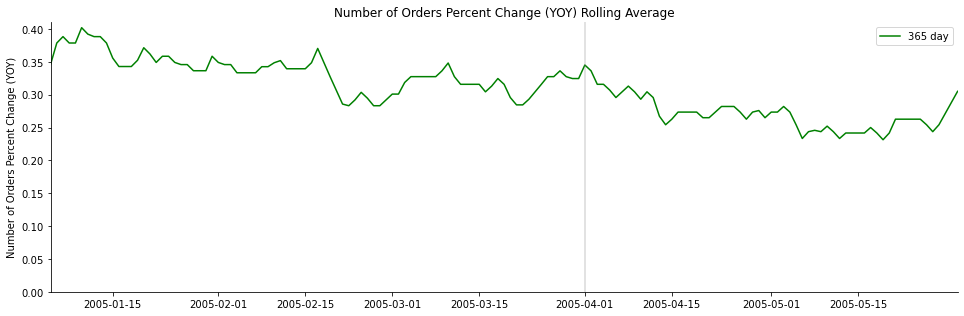

In [100]:
plot_lines('orders_yoy', period_start=4)

Orders slope with forecast

In [101]:
trend_start = np.mean(data_proj_roll.loc[start_dates['orders_yoy_roll_365']:,'orders_yoy_roll_365'][0])
trend_end = np.mean(data_proj_roll['orders_yoy_roll_365'][-1])
trend_distance = len(data_proj_roll.loc[start_dates['orders_yoy_roll_365']:,'orders_yoy_roll_365'].index)

trend_slope = (trend_end - trend_start) / trend_distance
np.round(trend_slope, 4)

-0.0003

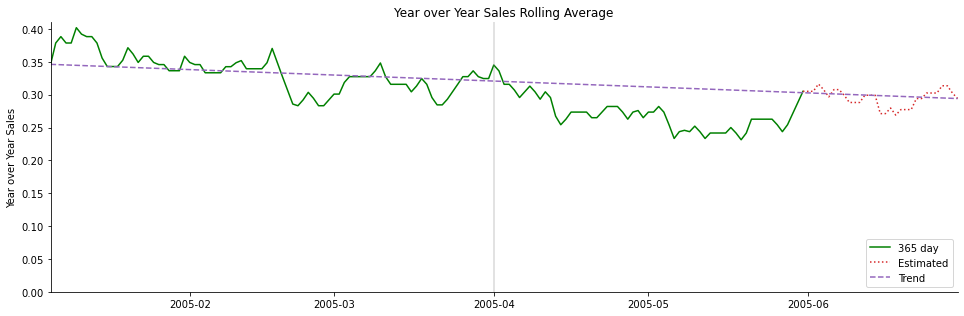

In [102]:
data_plot = data_proj_roll

metric = 'orders_yoy'
labels_metric[metric] = 'Year over Year Sales'
period_start = 0
period_end = 2
periods = [365]

# Inistantiate Figure
plt.figure(figsize=(w, h))

# Trend lines
min_period = np.inf
for period in periods[period_start:period_end]:
    sns.lineplot(data=data_plot.loc[(data_plot[f'{metric}_roll_{period}'] != 0).idxmax():data_daily_roll.index[-1], f'{metric}_roll_{period}'], color=color_dict[f'{period}day'])
    if period < min_period:
        min_period = period

    # Projected
    sns.lineplot(data=data_plot.loc[data_daily_roll.index[-1]:, f'{metric}_roll_{period}'], linestyle='dotted', color=sns.color_palette("tab10").as_hex()[3])

# Slope
# sns.lineplot(data=data_proj_roll.loc[start_dates['orders_yoy_roll_365']:,'orders_yoy_roll_365'].rolling(10, min_periods=1).mean())
sns.lineplot(
    x=data_proj_roll.loc[start_dates['orders_yoy_roll_365']:,'orders_yoy_roll_365'].index,
    y=np.linspace(start=trend_start, stop=trend_end, num=trend_distance), color=sns.color_palette("tab10").as_hex()[4],
    dashes=True, linestyle='dashed')
   
    
    

# Add quarterly breaks
new_date = pd.to_datetime(str((data_plot[f'{metric}_roll_{min_period}'] != 0).idxmax().year) + '-1-1')    # get minimum quarterly line from index of smallest period
upper_bound = data_plot[f'{metric}_roll_{min_period}'].max() + (data_plot[f'{metric}_roll_{min_period}'].max() * .02)   # get maximum height + 2% of smallest period
lower_bound = data_plot[f'{metric}_roll_{min_period}'].min() + (data_plot[f'{metric}_roll_{min_period}'].min() * .05)   # get maximum height + 2% of smallest period

while new_date < data_plot.index.max():
    plt.vlines(x=new_date, ymin=0, ymax=upper_bound, colors='gray', alpha=.3)
    new_date += pd.DateOffset(months=3)


plt.ylim((0, upper_bound))
plt.xlim(((data_plot[f'{metric}_roll_{min_period}'] != 0).idxmax(), data_plot.index[-1]))
plt.legend(labels=['365 day', 'Estimated', 'Trend'], loc='lower right')
plt.title(f'{labels_metric[metric]} Rolling Average')
plt.xlabel('')
plt.ylabel(labels_metric[metric])
plt.tight_layout()
sns.despine()
plt.show();

In [103]:
# Increase orders by 30% 
# Additional New orders
rate_of_increase = .3

adl_orders = q2_orders.sample(n=int((q2_orders.groupby('order')['order'].unique().shape[0] + new_orders.shape[0]) * rate_of_increase), replace=True)
adl_orders['order'] = adl_orders['order'] + 20000 # to know it is newly sampled data

# Assign random date to orders
for o in adl_orders.sort_values(by='order')['order'].unique():
    rand_date = np.random.choice(dates_future)
    adl_orders.loc[adl_orders['order']==o, 'date'] = rand_date

In [104]:
adl_orders.shape[0]

9

Estimated additional orders from marketing campaign

In [105]:
data_proj_adl = pd.concat([data_proj, adl_orders], ignore_index=True)
data_proj_adl.reset_index(drop=True, inplace=True)

In [106]:
data_proj_adl

,order,quantity,price,line,sales,date,status,qtr,month,year,...,state,postal,country,territory,cont_name_last,cont_name_first,size,adj_sales,msrp_ratio,msrp_class
0,10107,30,95.70,2,2871.00,2003-02-24,Shipped,1,2,2003,...,NY,10022,USA,AMER,Yu,Kwai,Small,2871.00,1.007368,normal
1,10121,34,81.35,5,2765.90,2003-05-07,Shipped,2,5,2003,...,NaN,51100,France,EMEA,Henriot,Paul,Small,2765.90,0.856316,normal
2,10134,41,94.74,2,3884.34,2003-07-01,Shipped,3,7,2003,...,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium,3884.34,0.997263,normal
3,10145,45,83.26,6,3746.70,2003-08-25,Shipped,3,8,2003,...,CA,90003,USA,AMER,Young,Julie,Medium,3746.70,0.876421,normal
4,10159,49,106.23,14,5205.27,2003-10-10,Shipped,4,10,2003,...,CA,94016,USA,AMER,Brown,Julie,Medium,5205.27,1.118211,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2733,30412,56,98.18,8,5498.08,2005-06-11,Shipped,2,5,2005,...,NaN,28034,Spain,EMEA,Freyre,Diego,Medium,5498.08,0.804754,normal
2734,30413,49,140.75,5,6896.75,2005-06-18,Shipped,2,5,2005,...,CT,97562,USA,AMER,King,Julie,Medium,6896.75,0.984266,normal
2735,30411,46,113.82,3,5235.72,2005-06-07,Shipped,2,5,2005,...,Quebec,H1J 1C3,Canada,AMER,Fresnisre,Jean,Medium,5235.72,0.940661,normal
2736,30419,32,119.77,10,3832.64,2005-06-19,Shipped,2,5,2005,...,NaN,5020,Austria,EMEA,Pipps,Georg,Medium,3832.64,1.041478,normal


In [107]:
data_proj_adl = pd.merge(left=pd.DataFrame(index=dates_proj), right=data_proj_adl.set_index('date').groupby('date')['order'].apply(lambda x: len(np.unique(x))), left_index=True, right_index=True, how='left')['order'].fillna(0).astype(int).to_frame()
data_proj_adl.rename({'order': 'orders'}, axis=1, inplace=True)

data_proj_adl['orders_roll_90'] = data_proj_adl['orders'].rolling(window=90).mean().fillna(0).to_frame()
data_proj_adl['orders_roll_365'] = data_proj_adl['orders'].rolling(window=365).mean().fillna(0).to_frame()

start_dates = (data_proj_adl != 0).idxmax()

data_proj_adl.loc[start_dates['orders_roll_90']:, 'orders_yoy_roll_90'] = data_proj_adl.loc[start_dates['orders_roll_90']:, 'orders_roll_90'].pct_change(366)
data_proj_adl.loc[start_dates['orders_roll_365']:, 'orders_yoy_roll_365'] = data_proj_adl.loc[start_dates['orders_roll_365']:, 'orders_roll_365'].pct_change(366)
data_proj_adl.fillna(0, inplace=True)

start_dates = (data_proj_adl != 0).idxmax()



data_proj_adl['adj_sales'] = 0
data_proj_adl.loc[data_proj.groupby('date').sum()['adj_sales'].index,'adj_sales'] = np.round(data_proj.groupby('date').sum()['adj_sales'], 2)

data_proj_adl['adj_sales_roll_90'] = data_proj_adl['adj_sales'].rolling(window=90).mean().fillna(0).to_frame()
data_proj_adl['adj_sales_roll_365'] = data_proj_adl['adj_sales'].rolling(window=365).mean().fillna(0).to_frame()


data_proj_adl

,orders,orders_roll_90,orders_roll_365,orders_yoy_roll_90,orders_yoy_roll_365,adj_sales,adj_sales_roll_90,adj_sales_roll_365
2003-01-06,1,0.000000,0.000000,0.000000,0.000000,12133.25,0.000000,0.000000
2003-01-07,0,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
2003-01-08,0,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
2003-01-09,1,0.000000,0.000000,0.000000,0.000000,11432.34,0.000000,0.000000
2003-01-10,1,0.000000,0.000000,0.000000,0.000000,6864.05,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2005-06-26,0,0.377778,0.441096,0.416667,0.352941,0.00,6834.768889,13141.595452
2005-06-27,0,0.377778,0.441096,0.416667,0.364407,0.00,6834.768889,13141.595452
2005-06-28,2,0.388889,0.443836,0.521739,0.372881,3387.78,6294.310111,13029.971507
2005-06-29,1,0.400000,0.446575,0.500000,0.369748,0.00,6294.310111,13029.971507


Orders slope with forecast

In [108]:
trend_start = np.mean(data_proj_adl.loc[start_dates['orders_yoy_roll_365']:,'orders_yoy_roll_365'][0])
trend_end = data_proj_adl['orders_yoy_roll_365'][-1]
trend_distance = len(data_proj_adl.loc[start_dates['orders_yoy_roll_365']:,'orders_yoy_roll_365'].index)

trend_slope = (trend_end - trend_start) / trend_distance
float(np.round(trend_slope, 4))

0.0001

New plot with additional projected data points

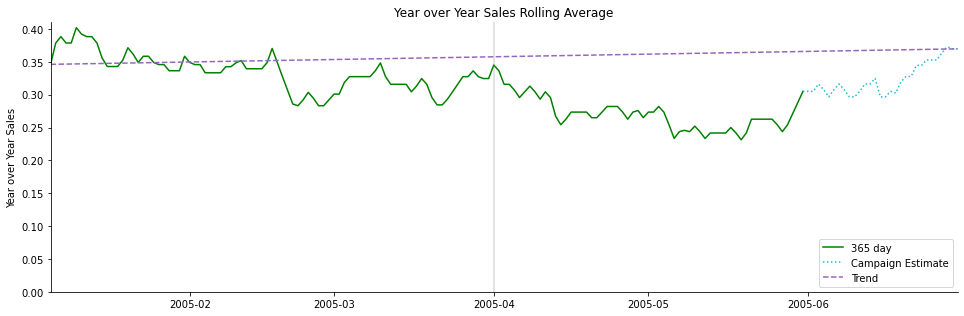

In [109]:
data_plot = data_proj_adl

metric = 'orders_yoy'
labels_metric[metric] = 'Year over Year Sales'
period_start = 0
period_end = 2
periods = [365]

# Inistantiate Figure
plt.figure(figsize=(w, h))

# Trend lines
min_period = np.inf
for period in periods[period_start:period_end]:
    sns.lineplot(data=data_plot.loc[(data_plot[f'{metric}_roll_{period}'] != 0).idxmax():data_daily_roll.index[-1], f'{metric}_roll_{period}'], color=color_dict[f'{period}day'])
    if period < min_period:
        min_period = period

    # Projected
    sns.lineplot(data=data_plot.loc[data_daily_roll.index[-1]:, f'{metric}_roll_{period}'], linestyle='dotted', color=sns.color_palette("tab10").as_hex()[9])

# Slope
# sns.lineplot(data=data_proj_roll.loc[start_dates['orders_yoy_roll_365']:,'orders_yoy_roll_365'].rolling(10, min_periods=1).mean())
sns.lineplot(
    x=data_proj_roll.loc[start_dates['orders_yoy_roll_365']:,'orders_yoy_roll_365'].index,
    y=np.linspace(start=trend_start, stop=trend_end, num=trend_distance), color=sns.color_palette("tab10").as_hex()[4],
    dashes=True, linestyle='dashed')
    

# Add quarterly breaks
new_date = pd.to_datetime(str((data_plot[f'{metric}_roll_{min_period}'] != 0).idxmax().year) + '-1-1')    # get minimum quarterly line from index of smallest period
upper_bound = data_plot[f'{metric}_roll_{min_period}'].max() + (data_plot[f'{metric}_roll_{min_period}'].max() * .02)   # get maximum height + 2% of smallest period
lower_bound = data_plot[f'{metric}_roll_{min_period}'].min() + (data_plot[f'{metric}_roll_{min_period}'].min() * .05)   # get maximum height + 2% of smallest period

while new_date < data_plot.index.max():
    plt.vlines(x=new_date, ymin=0, ymax=upper_bound, colors='gray', alpha=.3)
    new_date += pd.DateOffset(months=3)


plt.ylim((0, upper_bound))
plt.xlim(((data_plot[f'{metric}_roll_{min_period}'] != 0).idxmax(), data_plot.index[-1]))
plt.legend(labels=['365 day', 'Campaign Estimate', 'Trend'], loc='lower right')
plt.title(f'{labels_metric[metric]} Rolling Average')
plt.xlabel('')
plt.ylabel(labels_metric[metric])
plt.tight_layout()
sns.despine()
plt.show();

New Quarterly Outlook

In [110]:
# Convert month to quarter add year column
data_proj_adl = pd.merge(left=data_proj_adl, 
                           right=pd.DataFrame(
                               {'qtr': data_proj_adl.index.month.map(
                                       {1: 1, 2: 1, 3: 1,
                                        4: 2, 5: 2, 6: 2,
                                        7: 3, 8: 3, 9: 3,
                                        10: 4, 11: 4, 12: 4}),
                                'year': data_proj_adl.index.year,
                                                
                                        }, index=data_proj_adl.index),
                            how='left', left_index=True, right_index=True)

In [111]:
data_proj_adl[(data_proj_adl['qtr'] == 2) & (data_proj_adl['year'] == 2003)]['adj_sales'].sum()

562365.22

In [112]:
data_proj_adl[(data_proj_adl['qtr'] == 2) & (data_proj_adl['year'] == 2004)]['adj_sales'].sum()

620484.1699999999

In [113]:
data_proj_adl[(data_proj_adl['qtr'] == 2) & (data_proj_adl['year'] == 2005)]['adj_sales'].sum()

566487.91

In [114]:
# print('Quarterly Sales')
# q1_change = pd.Series(data_proj_adl[data_proj_adl['qtr']==1].groupby('year')['adj_sales'].sum(), name='Q1')
# q2_change = pd.Series(data_proj_adl[data_proj_adl['qtr']==2].groupby('year')['adj_sales'].sum(), name='Q2')
# q3_change = pd.Series(data_proj_adl[data_proj_adl['qtr']==3].groupby('year')['adj_sales'].sum(), name='Q3')
# q4_change = pd.Series(data_proj_adl[data_proj_adl['qtr']==4].groupby('year')['adj_sales'].sum(), name='Q4')
# _ = pd.concat([q1_change, q2_change, q3_change, q4_change], axis=1).T
# print(_)
# print()
# print('Change in Quarterly sales year over year')
# print(_.diff(axis=1))
# print()

# fig, ax = plt.subplots(figsize=(w, h))
# # 2005
# ax.bar(x=['Q1', 'Q2', 'Q3', 'Q4'], height=[_.iloc[0][2005], 0, 0, 0], color=sns.color_palette("tab10", 3).as_hex()[2], label='2005')
# ax.bar(x=['Q1', 'Q2', 'Q3', 'Q4'], height=[0, _.iloc[1][2005], 0, 0], color=sns.color_palette("tab10", 3).as_hex()[2])

# # 2004
# ax.bar(x=['Q1', 'Q2', 'Q3', 'Q4'], height=[_.iloc[0][2004], 0, 0, 0], color=sns.color_palette("tab10", 2).as_hex()[1], label='2004')
# ax.bar(x=['Q1', 'Q2', 'Q3', 'Q4'], height=[0, _.iloc[1][2004],  0, 0], color=sns.color_palette("tab10", 2).as_hex()[1])
# ax.bar(x=['Q1', 'Q2', 'Q3', 'Q4'], height=[0, 0, _.iloc[2][2004], 0], color=sns.color_palette("tab10", 2).as_hex()[1])
# ax.bar(x=['Q1', 'Q2', 'Q3', 'Q4'], height=[0, 0, 0, _.iloc[3][2004]], color=sns.color_palette("tab10", 2).as_hex()[1])

# # 2003
# ax.bar(x=['Q1', 'Q2', 'Q3', 'Q4'], height=[_.iloc[0][2003], 0, 0, 0], color=sns.color_palette("tab10", 1).as_hex()[0], label='2003')
# ax.bar(x=['Q1', 'Q2', 'Q3', 'Q4'], height=[0, _.iloc[1][2003],  0, 0], color=sns.color_palette("tab10", 1).as_hex()[0])
# ax.bar(x=['Q1', 'Q2', 'Q3', 'Q4'], height=[0, 0, _.iloc[2][2003], 0], color=sns.color_palette("tab10", 1).as_hex()[0])
# ax.bar(x=['Q1', 'Q2', 'Q3', 'Q4'], height=[0, 0, 0, _.iloc[3][2003]], color=sns.color_palette("tab10", 1).as_hex()[0])

# # Pct Change
# q1_change_pct = pd.Series(data_proj_adl[data_proj_adl['qtr']==1].groupby('year')['adj_sales'].sum().pct_change(), name='Q1')
# q2_change_pct = pd.Series(data_proj_adl[data_proj_adl['qtr']==2].groupby('year')['adj_sales'].sum().pct_change(), name='Q2')
# q3_change_pct = pd.Series(data_proj_adl[data_proj_adl['qtr']==3].groupby('year')['adj_sales'].sum().pct_change(), name='Q3')
# q4_change_pct = pd.Series(data_proj_adl[data_proj_adl['qtr']==4].groupby('year')['adj_sales'].sum().pct_change(), name='Q4')

# # Labels

# plt.annotate(f'+{np.round(q1_change_pct[2005]*100, 1)}%', xy=(-.125, int(_[2004][0] + 40000 + (_.diff(axis=1)[2005][0])) ), size=12)
# plt.annotate(f'+{np.round(q2_change_pct[2005]*100, 1)}%', xy=(-.125, int(_[2004][1] + 40000 + (_.diff(axis=1)[2005][1])) ), size=12)

# plt.annotate(f'+{np.round(q1_change_pct[2004]*100, 1)}%', xy=(-.125, int(_[2003][0] + 40000 + (_.diff(axis=1)[2004][0])) ), size=12)
# plt.annotate(f'+{np.round(q2_change_pct[2004]*100, 1)}%', xy=(0.875, int(_[2003][1] + 40000 + (_.diff(axis=1)[2004][1])) ), size=12)
# plt.annotate(f'+{np.round(q3_change_pct[2004]*100, 1)}%', xy=(1.875, int(_[2003][2] + 40000 + (_.diff(axis=1)[2004][2])) ), size=12)
# plt.annotate(f'+{np.round(q4_change_pct[2004]*100, 1)}%', xy=(2.9, int(_[2003][3] + 40000 + (_.diff(axis=1)[2004][3])) ), size=12)

# # Chart labels
# plt.legend()
# plt.yticks(ticks=plt.gca().get_yticks(), labels=['', '$250k', '$500k', '$750k', '$1.0M', '$1.25M', '$1.5M', '$1.75M', '$2.0M', ''])
# plt.title('Year Over Year Quarterly Sales')
# sns.despine()

# # 
# print('Percent Change')
# __ = pd.concat([q1_change_pct, q2_change_pct, q3_change_pct, q4_change_pct], axis=1).T
# print(__)

# # Show graph
# plt.show()
